# Elo Merchant Category Recommendation - Effect of target outliers on RMSE <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("input/train.csv")
df = reduce_mem_usage(df)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)


# Can we improve?
We want to check how the proportion of correctly predicted target outliers (aprox -33.21) affects the RMSE. In order to decide if it is worth it to train some kind of churn model. The rest of the target values are merely predicted as the mean value of all the normal targets.

In [4]:
n = df.shape[0]
prop = np.linspace(0.5, 1, 6)
RMSE = [0]*len(prop)

# Compute the mean of the normal scores
target_mean = df[df['target']>-33]['target'].mean()   
print("Mean without outliers: {:}".format(target_mean))

Mean without outliers: -0.0


In [5]:
df_out = df[df['target']<-33]['target']
out = df_out.values[0]
n_out = df_out.shape[0]
targets = np.concatenate((df_out.values, df[df['target']>-33]['target'].values))

for i in range(len(prop)):
    n_ok = int(round(prop[i]*n_out))
    pred = [out]*n_ok + [0]*(n-n_ok)
    RMSE[i] = mean_squared_error(targets, pred) #math.sqrt(((pred-targets)**2).mean())

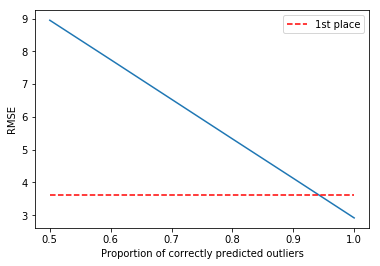

In [6]:
plt.plot(prop, RMSE)
plt.xlabel("Proportion of correctly predicted outliers")
plt.plot(prop, [3.61]*len(prop), 'r--', label="1st place")
plt.ylabel("RMSE")
plt.legend(loc='upper right')

# Churn model

In [7]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [8]:
df_trans = pd.concat([df_hist_trans, df_new_trans])
df_trans = df_trans[df_trans['card_id'].isin(df['card_id'].unique())].reset_index()
df_trans.head()

,index,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,400,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37
1,401,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19
2,402,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33
3,403,Y,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19
4,404,Y,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33


## Feature extraction
First, all the features regarding amount of transactions should be rescaled to get meaninful values. Some features that may be useful for churn prediction: 
- Total amount of transactions
- Median value of purchase amount
- Number of different merchants
- Some measures of stability over time. Although we can not do it properly grouping by merchants, since the transaction data are limited to (at most) three consecutive months for the same merchant.
    - Time since the last transaction.
    - Mean purchase amount in the last month (or 2 or 3) compared with the mean amount.
    - Some measure of how many merchants users have stopped visiting (although it may be difficult taking into account that the transactions are limited to 3 months per merchant)
    - Time between transactions for prefered merchant (to check if it increases over time)
- Maybe if they have transactions in for new merchants (new transactions file), it means that they keep using the card.

In [80]:
df['churn'] = 1*(df['target']<-33)
df_trans['purchase_amount_raw'] = df_trans['purchase_amount']/0.00150265118 + 497.06
df_trans = df_trans[df_trans['authorized_flag']=='Y'] #We will only use authorized transactions

In [81]:
df_amount_trans = df_trans.groupby('card_id')['purchase_amount_raw'].sum().reset_index().rename(columns={'purchase_amount_raw': 'sum_purchase_amount'})
df_n_trans = df_trans.groupby('card_id')['purchase_amount_raw'].count().reset_index().rename(columns={'purchase_amount_raw': 'n_purchase_amount'})
df_n_merch = df_trans.groupby('card_id')['merchant_id'].nunique().reset_index().rename(columns={'merchant_id': 'n_merchant'})

In [82]:
#only use cards with transactions
df_log = df.join(df_amount_trans.set_index('card_id'), on='card_id', how='inner') 
df_log = df_log.join(df_n_trans.join(df_n_merch.set_index('card_id'), on='card_id').set_index('card_id'), on='card_id')

In [83]:
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0,20646.298828,270,116
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,0,29577.232422,345,147
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,0,1890.995972,42,14
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,0,5719.293945,84,57
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0,22311.408203,164,101


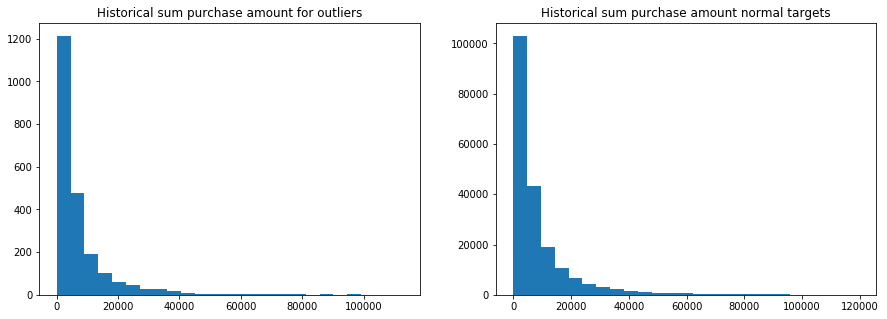

In [84]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.sum_purchase_amount < 120000)]['sum_purchase_amount'], bins=25)
plt.title('Historical sum purchase amount for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.sum_purchase_amount < 120000)]['sum_purchase_amount'], bins=25)
plt.title('Historical sum purchase amount normal targets')
plt.show()

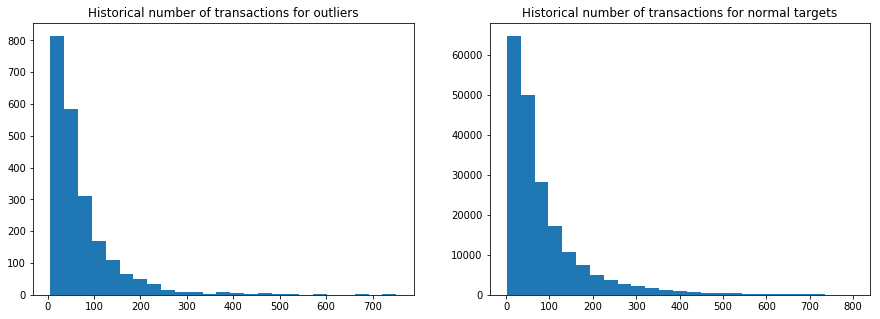

In [85]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.n_purchase_amount < 800)]['n_purchase_amount'], bins=25)
#plt.hist(df_log[df.target<-33]['n_purchase_amount'], bins=25)
plt.title('Historical number of transactions for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.n_purchase_amount < 800)]['n_purchase_amount'], bins=25)
#plt.hist(df_log[df.target>-33]['n_purchase_amount'], bins=25)
plt.title('Historical number of transactions for normal targets')
plt.show()

It seems that the outliers have slightly less number of transactions that the normal users.

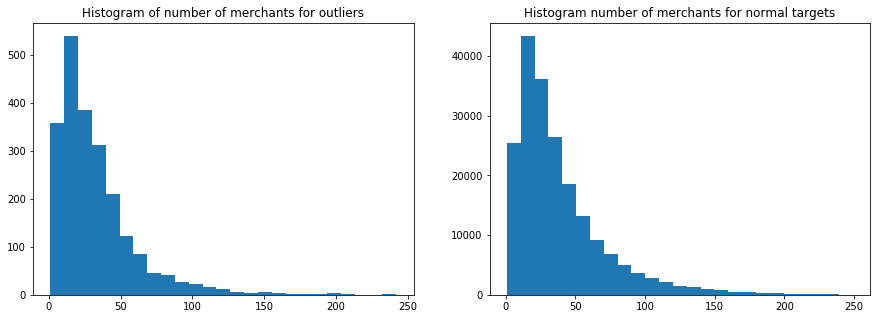

In [86]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df.target<-33) & (df_log.n_merchant < 250)]['n_merchant'], bins=25)
#plt.hist(df_log[df.target<-33]['n_merchant'], bins=25)
plt.title('Histogram of number of merchants for outliers')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df.target>-33) & (df_log.n_merchant < 250)]['n_merchant'], bins=25)
#plt.hist(df_log[df.target>-33]['n_merchant'], bins=25)
plt.title('Histogram number of merchants for normal targets')
plt.show()

The outliers also seem to have less number of different merchants.

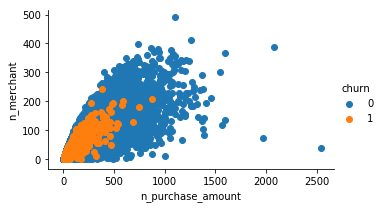

In [87]:
fg = sns.FacetGrid(data=df_log, hue='churn', aspect=1.61)
fg.map(plt.scatter, 'n_purchase_amount','n_merchant').add_legend()

Let's see if we can see something different in the purchase curves if the users that are undistinguible with these two features.

In [88]:
def create_date_year_month(df, source_column, preposition):
    df[preposition + '_ym'] = df[source_column].dt.strftime('%Y') + '-' + df[source_column].dt.strftime('%m')    
    return df
df_trans['purchase_date'] = pd.to_datetime(df_trans['purchase_date'])
df_trans = create_date_year_month(df_trans, 'purchase_date', 'purchase')

In [89]:
outs_ids = df_log[(df.target<-33) & (df_log.n_purchase_amount < 300) & (df_log.n_purchase_amount > 250) & (df_log.n_merchant < 100) & (df_log.n_merchant > 80)]['card_id'].values
normals_ids = df_log[(df.target>-33) & (df_log.n_purchase_amount < 300) & (df_log.n_purchase_amount > 250) & (df_log.n_merchant < 100) & (df_log.n_merchant > 80)].head(4)['card_id'].values

In [168]:
df_outs_plot = df_trans[df_trans['card_id'].isin(outs_ids)].groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_outs_plot.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_550f606893,2017-01,524.529785
1,C_ID_550f606893,2017-02,471.359894
2,C_ID_550f606893,2017-03,1817.319336
3,C_ID_550f606893,2017-04,1033.859863
4,C_ID_550f606893,2017-05,408.099884


In [169]:
df_normals_plot = df_trans[df_trans['card_id'].isin(normals_ids)].groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_normals_plot.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_37e3d6be84,2017-03,259.799774
1,C_ID_37e3d6be84,2017-04,119.199921
2,C_ID_37e3d6be84,2017-05,499.939453
3,C_ID_37e3d6be84,2017-06,701.869263
4,C_ID_37e3d6be84,2017-07,283.079468


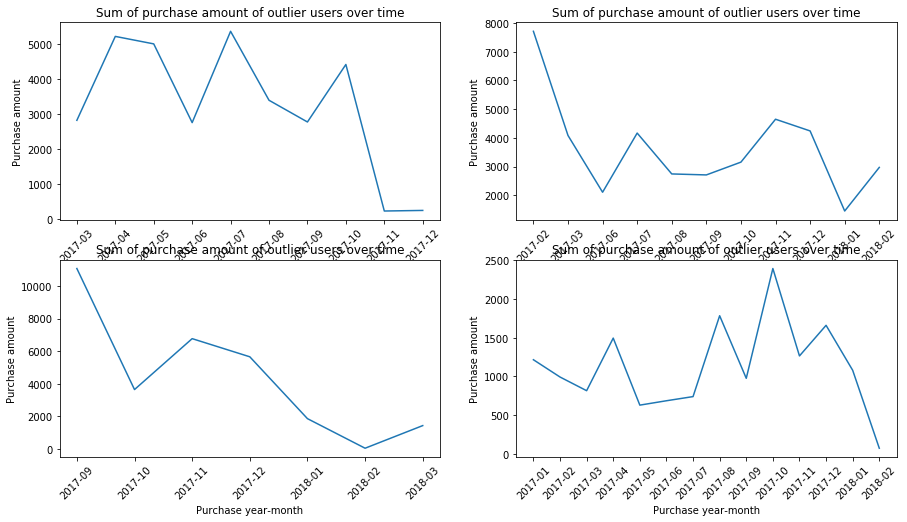

In [92]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_outs_plot[df_outs_plot.card_id==outs_ids[i]]['purchase_ym'], y=df_outs_plot[df_outs_plot.card_id==outs_ids[i]]['purchase_amount_raw'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Sum of purchase amount of outlier users over time')
    ax.set_xlabel('Purchase year-month')
    ax.set_ylabel('Purchase amount')
plt.show()

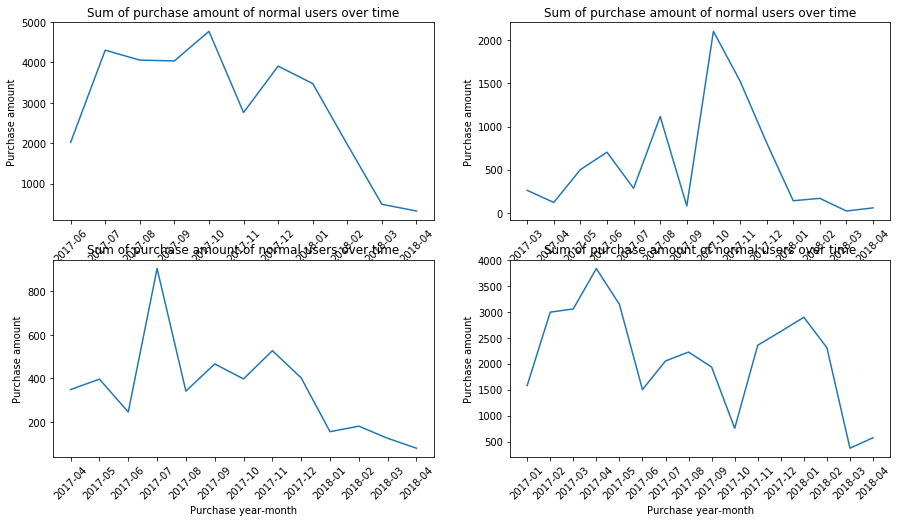

In [93]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_normals_plot[df_normals_plot.card_id==normals_ids[i]]['purchase_ym'], y=df_normals_plot[df_normals_plot.card_id==normals_ids[i]]['purchase_amount_raw'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Sum of purchase amount of normal users over time')
    ax.set_xlabel('Purchase year-month')
    ax.set_ylabel('Purchase amount')
plt.show()

It seems that the outlier users tend to expend more money at the begining, while the normal users tend to have the maximum values in the middle. Then we will adjust a second degree polynomial to the curves and check the coefficient of $x^2$.

In [121]:
def compute_shape(user):
    grid = np.linspace(-1,1,user['purchase_ym'].nunique())
    coeffs = np.polyfit(grid, user.groupby('purchase_ym')['purchase_amount_raw'].sum().values, 2)
    return(pd.DataFrame({'purchase_shape': [np.sign(coeffs[0])]}))

df_coeffs = df_trans.groupby('card_id')[['purchase_ym','purchase_amount_raw']].apply(compute_shape)
df_coeffs = df_coeffs.reset_index(level=0)

In [136]:
df_log = df_log.join(df_coeffs.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0,20646.298828,270,116,-1.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,0,29577.232422,345,147,1.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,0,1890.995972,42,14,1.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,0,5719.293945,84,57,-1.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0,22311.408203,164,101,-1.0


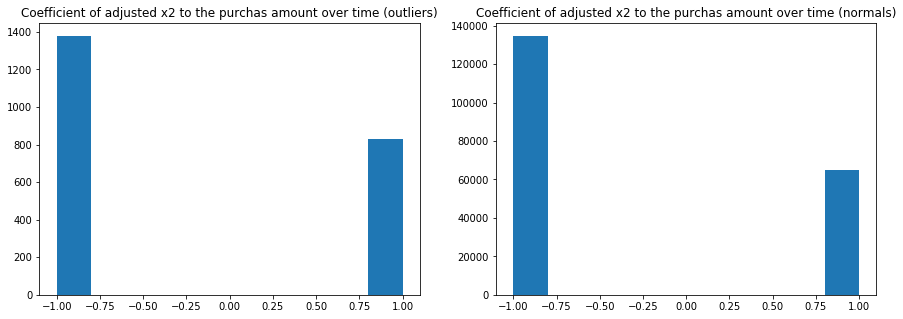

In [139]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[df_log['target']<-33]['purchase_shape'])
plt.title('Coefficient of adjusted x2 to the purchas amount over time (outliers)')
plt.subplot(1, 2, 2)
plt.hist(df_log[df_log['target']>-33]['purchase_shape'])
plt.title('Coefficient of adjusted x2 to the purchas amount over time (normals)')
plt.show()

We don't see a significative difference in the histograms of both sets, although it seems that the proportion of 1's for outliers in slightly bigger. <br>
Let's try to use the number of transactions instead of the amount.

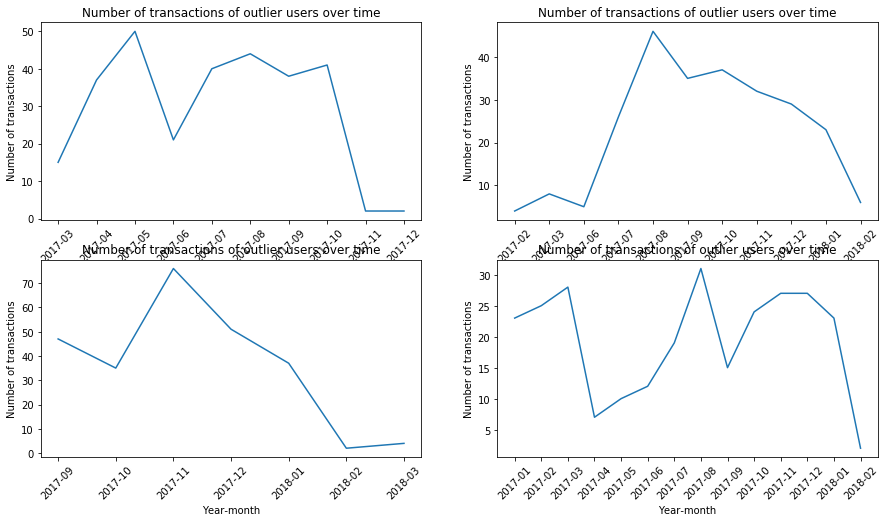

In [147]:
df_outs_temp = df_trans[df_trans['card_id'].isin(outs_ids)].groupby(['card_id','purchase_ym']).size().reset_index().rename({0:'n_trans'}, axis=1)
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_outs_temp[df_outs_temp.card_id==outs_ids[i]]['purchase_ym'], y=df_outs_temp[df_outs_temp.card_id==outs_ids[i]]['n_trans'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Number of transactions of outlier users over time')
    ax.set_xlabel('Year-month')
    ax.set_ylabel('Number of transactions')
plt.show()

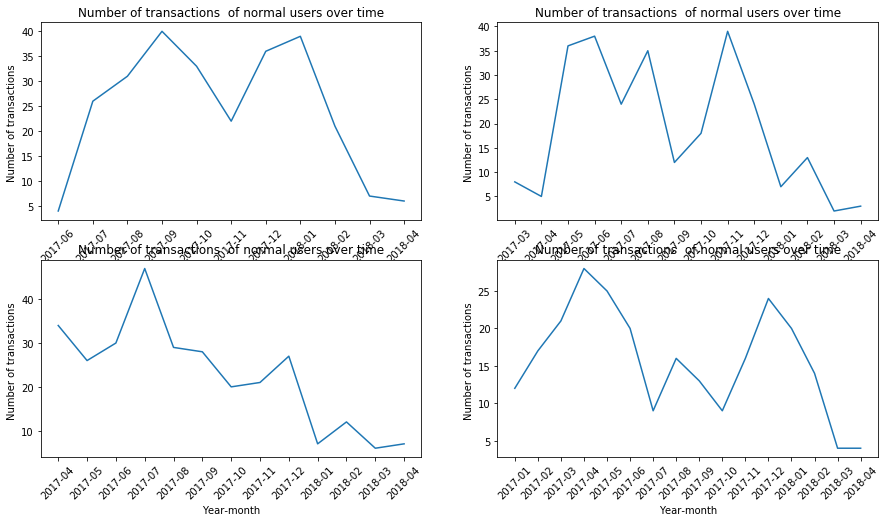

In [148]:
df_normals_temp = df_trans[df_trans['card_id'].isin(normals_ids)].groupby(['card_id','purchase_ym']).size().reset_index().rename({0:'n_trans'}, axis=1)
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=df_normals_temp[df_normals_temp.card_id==normals_ids[i]]['purchase_ym'], y=df_normals_temp[df_normals_temp.card_id==normals_ids[i]]['n_trans'], markers = True, dashes = False)
    plt.xticks(rotation = 45)
    ax.set_title('Number of transactions  of normal users over time')
    ax.set_xlabel('Year-month')
    ax.set_ylabel('Number of transactions')
plt.show()

It doesn't seem to be a big different neither. The number of transactions in both groups decay with time. It might be because the data is truncated only to windows of 3 months for each user and merchant... <br>
One could thought that the outlier users may have used the cards quite often at some point, but they lost insterest, while the normal users keep is normal behavior. Let's try to find some feature of this regard (for instance the ratio between the maximum and median values over time should be grater for outliers).

In [149]:
df_amounts_over_time = df_trans.groupby(['card_id','purchase_ym'])['purchase_amount_raw'].sum().reset_index()
df_amounts_over_time.head()

,card_id,purchase_ym,purchase_amount_raw
0,C_ID_00007093c1,2017-02,1100.199951
1,C_ID_00007093c1,2017-03,866.899902
2,C_ID_00007093c1,2017-04,1203.249878
3,C_ID_00007093c1,2017-05,686.999939
4,C_ID_00007093c1,2017-06,1464.599854


In [155]:
def ratio_max_amount(amounts):
    return(pd.DataFrame({'ratio_amount': [amounts.max()/amounts.median()]}))
df_ratios = df_amounts_over_time.groupby('card_id')['purchase_amount_raw'].apply(ratio_max_amount)
df_ratios.head()

,,ratio_amount
card_id,,
C_ID_00007093c1,0,2.497954
C_ID_0001506ef0,0,1.944136
C_ID_000183fdda,0,3.906667
C_ID_00027503e2,0,1.529051
C_ID_0002c7c2c1,0,2.468608


In [161]:
df_ratios = df_ratios.reset_index(level=0)
df_log = df_log.join(df_ratios.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0,20646.298828,270,116,-1.0,6.788005
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,0,29577.232422,345,147,1.0,2.729797
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,0,1890.995972,42,14,1.0,3.782484
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,0,5719.293945,84,57,-1.0,5.460994
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0,22311.408203,164,101,-1.0,2.587446


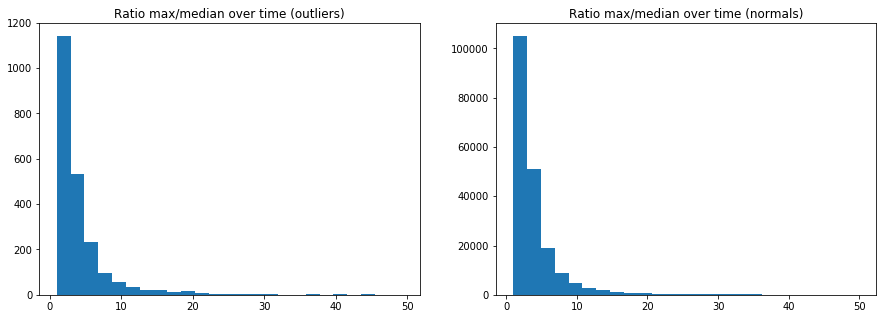

In [167]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_log[(df_log['target']<-33) & (df_log['ratio_amount']<50)]['ratio_amount'], bins=25)
plt.title('Ratio max/median over time (outliers)')
plt.subplot(1, 2, 2)
plt.hist(df_log[(df_log['target']>-33) & (df_log['ratio_amount']<50)]['ratio_amount'], bins=25)
plt.title('Ratio max/median over time (normals)')
plt.show()

The observed difference, although it's in line with expectations, is too little to be useful.

Another way to see if a user lost interest in the product is checking the differences between the usages of the card. 

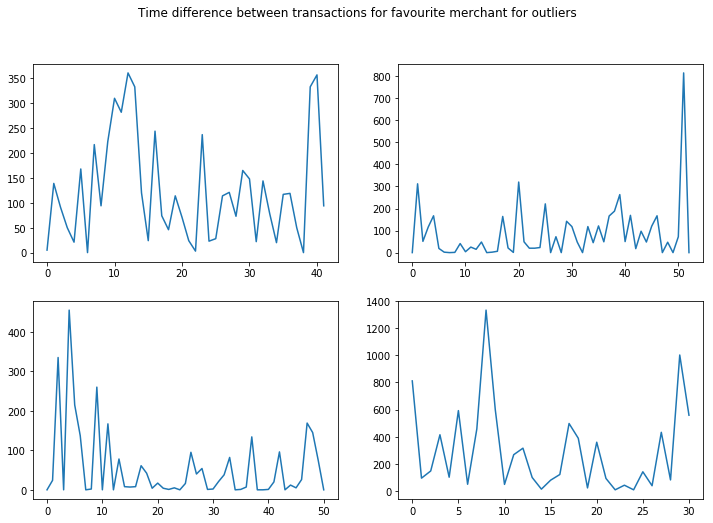

In [228]:
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    id_merch_out_temp = df_trans[df_trans['card_id']==outs_ids[i]].groupby('merchant_id').size().reset_index().rename(columns={0:'n_merch'}).sort_values('n_merch',ascending=False).head(1)['merchant_id'].values[0]
    dates_out_temp = df_trans[(df_trans['card_id']==outs_ids[i]) & (df_trans['merchant_id']==id_merch_out_temp)].sort_values('purchase_date')['purchase_date'].values
    plt.plot(np.diff(dates_out_temp)/3.6e+12)
    plt.suptitle("Time difference between transactions for favourite merchant for outliers")
plt.show()

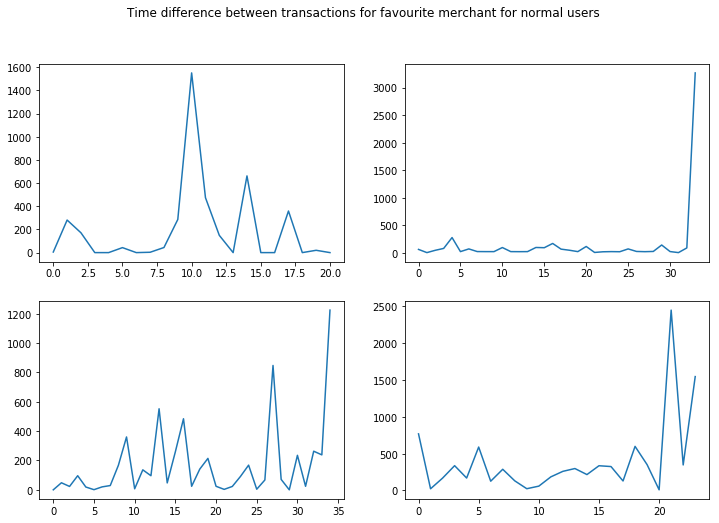

In [227]:
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    id_merch_norm_temp = df_trans[df_trans['card_id']==normals_ids[i]].groupby('merchant_id').size().reset_index().rename(columns={0:'n_merch'}).sort_values('n_merch',ascending=False).head(1)['merchant_id'].values[0]
    dates_norm_temp = df_trans[(df_trans['card_id']==normals_ids[i]) & (df_trans['merchant_id']==id_merch_norm_temp)].sort_values('purchase_date')['purchase_date'].values
    plt.plot(np.diff(dates_norm_temp)/3.6e+12)
plt.suptitle("Time difference between transactions for favourite merchant for normal users")
plt.show()

It doesn't seem to be a pattern in the differences to distinguish both groups, since the behavour that one would expect for the outliers is more similar to the one observed in the normal users. It fact, it seems that the time differences for normal users is larger than the outliers. We could also measure the standard deviation, since it may be more variability for the outliers.

In [307]:
def diff_times_fav(user):
    #id_merch_temp = user.groupby('merchant_id').size().reset_index().rename(columns={0:'n_merch'}).sort_values('n_merch',ascending=False).head(1)['merchant_id'].values[0]
    id_merch_temp = user.groupby('merchant_id').size().idxmax()
    dates_temp = user[user['merchant_id']==id_merch_temp].sort_values('purchase_date')['purchase_date'].values
    diff_temp = (np.diff(dates_temp)/3.6e+12).astype(float)
    return(pd.DataFrame({'diff_time_fav_mean': [diff_temp.mean()], 'diff_time_fav_std': [diff_temp.std()]}))

df_diff_times = df_trans.groupby('card_id')[['merchant_id','purchase_date']].apply(diff_times_fav)
df_diff_times = df_diff_times.reset_index(level=0)
df_diff_times.head()

,card_id,diff_time_mean,diff_time_std
0,C_ID_00007093c1,278.100000,303.042830
0,C_ID_0001506ef0,492.166667,318.086685
0,C_ID_000183fdda,365.818182,487.926190
0,C_ID_00027503e2,541.800000,537.363527
0,C_ID_0002c7c2c1,708.428571,667.418236


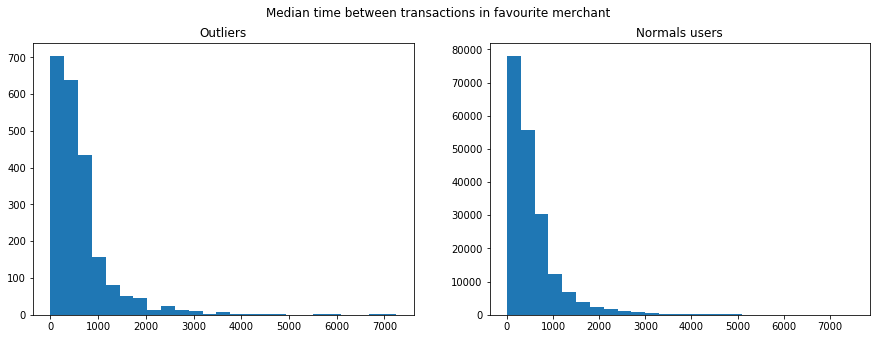

In [319]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_outs)) & (df_diff_times['diff_time_fav_mean']<7500)]['diff_time_fav_mean'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_norms)) & (df_diff_times['diff_time_fav_mean']<7500)]['diff_time_fav_mean'], bins=25)
plt.title('Normals users')
plt.suptitle('Median time between transactions in favourite merchant')
plt.show()

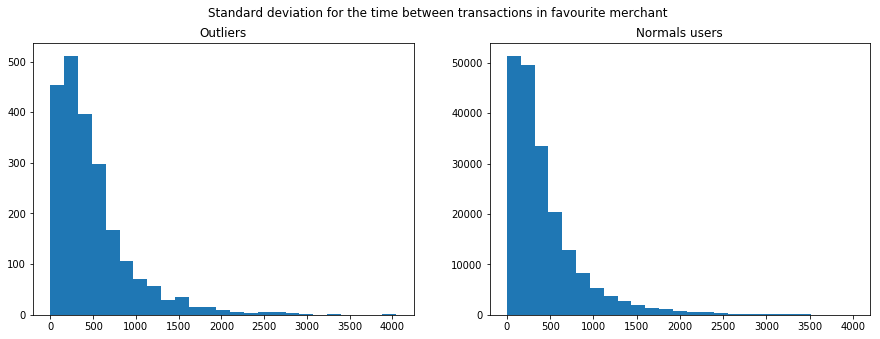

In [317]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ids_all_outs = df[df['target']<-33]['card_id'].values
ids_all_norms = df[df['target']>-33]['card_id'].values
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_outs)) & (df_diff_times['diff_time_fav_std']<4100)]['diff_time_fav_std'], bins=25)
plt.title('Outliers')
plt.subplot(1, 2, 2)
plt.hist(df_diff_times[(df_diff_times['card_id'].isin(ids_all_norms)) & (df_diff_times['diff_time_fav_std']<4000)]['diff_time_fav_std'], bins=25)
plt.title('Normals users')
plt.suptitle('Standard deviation for the time between transactions in favourite merchant')
plt.show()

It seems that both the mean and the std of the outliers is greater than for the normal users, specially the std. (pintar el grafico de dispersion para las dos medidas)

In [314]:
df_log = df_log.join(df_diff_times.set_index('card_id'), on='card_id') 
df_log.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,churn,sum_purchase_amount,n_purchase_amount,n_merchant,purchase_shape,ratio_amount,diff_time_fav_mean,diff_time_fav_std
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,0,20646.298828,270,116,-1.0,6.788005,63.600000,69.857283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,0,29577.232422,345,147,1.0,2.729797,373.920000,505.526333
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,0,1890.995972,42,14,1.0,3.782484,313.480000,360.365827
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,0,5719.293945,84,57,-1.0,5.460994,410.000000,488.171589
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,0,22311.408203,164,101,-1.0,2.587446,94.259259,95.007053


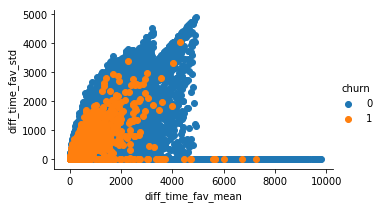

In [315]:
fg = sns.FacetGrid(data=df_log, hue='churn', aspect=1.61)
fg.map(plt.scatter, 'diff_time_fav_mean','diff_time_fav_std').add_legend()

This graph has a bit extrange shape for normal users, since it seems to have two differenciated peaks. But I have no idea what does it mean... It seems to be a straight line (maybe y=x). Besides, the users with largest times between transactions have zero standard deviation, which means that all the transactions were made with the same time distance. These may correspond to the merchants providing monthly subscriptions.

(repeat the same but with all the transactions and not only the most common merchant, since this measure might by distorted by the 3 months limit)